In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import ipywidgets as widgets
from IPython.display import display

In [20]:
df_target = pd.read_csv("lucas_organic_carbon_target.csv")
df_test = pd.read_csv("lucas_organic_carbon_training_and_test_data.csv")

In [21]:
df_target.head()

,x
0,very_low
1,very_low
2,very_low
3,moderate
4,low


In [22]:
df_test.head()

,500.0,500.5,501.0,501.5,502.0,502.5,503.0,503.5,504.0,504.5,...,2495.0,2495.5,2496.0,2496.5,2497.0,2497.5,2498.0,2498.5,2499.0,2499.5
0,0.000276,0.000278,0.000280,0.000281,0.000283,0.000284,0.000286,0.000288,0.000289,0.000291,...,-0.000070,-0.000068,-0.000065,-0.000063,-0.000060,-0.000058,-0.000056,-0.000053,-0.000051,-0.000048
1,0.000351,0.000353,0.000355,0.000357,0.000358,0.000360,0.000362,0.000364,0.000366,0.000368,...,-0.000041,-0.000038,-0.000036,-0.000034,-0.000031,-0.000029,-0.000026,-0.000024,-0.000022,-0.000019
2,0.000330,0.000331,0.000333,0.000335,0.000337,0.000339,0.000341,0.000343,0.000344,0.000346,...,-0.000086,-0.000084,-0.000081,-0.000079,-0.000076,-0.000074,-0.000072,-0.000069,-0.000067,-0.000064
3,0.000300,0.000303,0.000305,0.000307,0.000309,0.000312,0.000314,0.000316,0.000318,0.000320,...,-0.000109,-0.000105,-0.000100,-0.000096,-0.000092,-0.000088,-0.000084,-0.000080,-0.000076,-0.000072
4,0.000388,0.000390,0.000391,0.000393,0.000395,0.000397,0.000399,0.000401,0.000403,0.000405,...,-0.000076,-0.000074,-0.000072,-0.000070,-0.000067,-0.000065,-0.000063,-0.000061,-0.000059,-0.000057


In [23]:
X = df_test  # Features
y = df_target['x']

# Daten aufteilen
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Random Forest trainieren
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Feature Importance
importances = model.feature_importances_
feature_names = X.columns
sorted_indices = importances.argsort()[::-1][:10]  # Indizes der Top 10 Features

top_features = feature_names[sorted_indices]
top_importances = importances[sorted_indices]

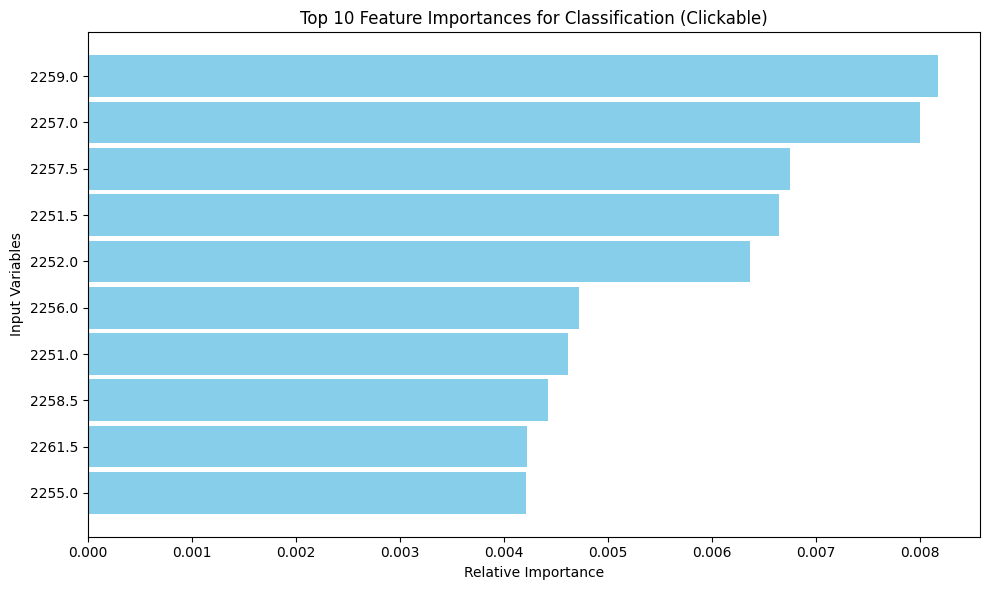

In [24]:
# Visualisierung mit dickeren Bars für bessere Interaktion
plt.figure(figsize=(10, 6))
bars = plt.barh(top_features, top_importances, color="skyblue", height=0.9)
plt.xlabel("Relative Importance")
plt.ylabel("Input Variables")
plt.title("Top 10 Feature Importances for Classification (Clickable)")
plt.gca().invert_yaxis()  # Wichtigste oben anzeigen
plt.tight_layout()

# Speichern der Feature-Informationen in der Figure selbst
fig = plt.gcf()
fig.top_features = top_features
fig.top_importances = top_importances

def on_click(event):
    if event.inaxes == plt.gca():
        # Umrechnung der Mausposition in Datenkoordinaten
        y_pos = event.ydata
        inv = plt.gca().invert_yaxis.inverted()
        y_pos = inv.transform((0, y_pos))[1]

        # Finde den nächstgelegenen Balken
        idx = int(round(y_pos))
        
        if 0 <= idx < len(fig.top_features):
            feature = fig.top_features[idx]
            importance = fig.top_importances[idx]
            
            # Erstelle ein neues Figure-Objekt für das Histogramm
            fig_hist = plt.figure(figsize=(10, 4))
            
            # Histogramm plotten
            for target_class in np.unique(y):
                mask = y == target_class
                plt.hist(X[feature][mask], 
                         alpha=0.5, 
                         label=target_class, 
                         bins=30,
                         density=True)
            
            plt.title(f'Distribution of {feature} (Importance: {importance:.4f})')
            plt.xlabel(feature)
            plt.ylabel('Density')
            plt.legend()
            plt.show(block=False)  # Nicht blockierend

# Verbinde den Klick-Event mit der Funktion
fig.canvas.mpl_connect('button_press_event', on_click)
plt.show()

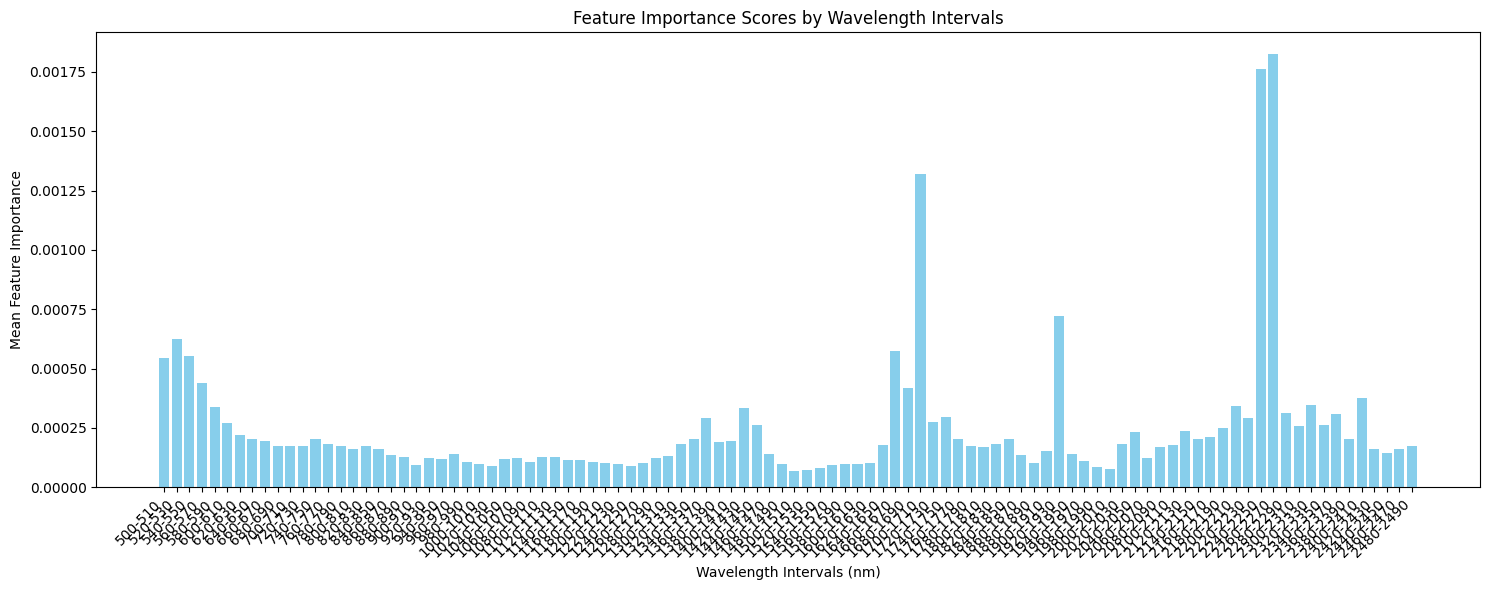


Top 10 most important intervals:
      Interval  Mean Importance
175  2250-2260         0.004346
176  2260-2270         0.001825
174  2240-2250         0.001763
141  1910-1920         0.001411
120  1700-1710         0.001320
121  1710-1720         0.001002
142  1920-1930         0.000720
2      520-530         0.000626
173  2230-2240         0.000608
117  1670-1680         0.000578


In [25]:
# Calculate intervals (every 10 wavelengths)
wavelengths = feature_names.astype(float)
interval_size = 10
intervals = []
interval_scores = []

# Create intervals and calculate mean importance for each interval
for start in range(int(wavelengths.min()), int(wavelengths.max()), interval_size):
    end = start + interval_size
    
    # Get features within this interval
    mask = (wavelengths >= start) & (wavelengths < end)
    interval_features = feature_names[mask]
    
    if len(interval_features) > 0:
        # Calculate mean importance for this interval
        interval_importance = importances[mask].mean()
        intervals.append(f"{start}-{end}")
        interval_scores.append(interval_importance)

# Create plot
plt.figure(figsize=(15, 6))
plt.bar(intervals[::2], interval_scores[::2], color='skyblue')  # Plot every second bar for better readability
plt.xticks(rotation=45, ha='right')
plt.xlabel("Wavelength Intervals (nm)")
plt.ylabel("Mean Feature Importance")
plt.title("Feature Importance Scores by Wavelength Intervals")
plt.tight_layout()
plt.show()

# Create DataFrame with results
interval_results = pd.DataFrame({
    'Interval': intervals,
    'Mean Importance': interval_scores
})
print("\nTop 10 most important intervals:")
print(interval_results.nlargest(10, 'Mean Importance'))

In [26]:
# Create slider widget for interval selection
slider = widgets.IntRangeSlider(
    value=[500, 600],  # Default range
    min=500,           # Minimum wavelength
    max=2500,          # Maximum wavelength
    step=10,           # Step size
    description='Wavelength Range (nm):',
    continuous_update=False,
    layout=widgets.Layout(width='600px')
)

def calculate_error(change):
    # Get selected range from slider
    start, end = change['new']
    
    # Select features within the range
    selected_features = [col for col in X.columns if start <= float(col) <= end]
    X_selected = X[selected_features]
    
    # Split data with selected features
    X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(
        X_selected, y, test_size=0.3, random_state=42
    )
    
    # Train model with selected features
    model_selected = RandomForestClassifier(random_state=42)
    model_selected.fit(X_train_selected, y_train_selected)
    
    # Make predictions
    y_pred = model_selected.predict(X_test_selected)
    
    # Calculate and display classification report
    report = classification_report(y_test_selected, y_pred)
    print(f"\nClassification Report for wavelength range {start}-{end} nm:")
    print(report)

# Connect slider to calculation function
slider.observe(calculate_error, names='value')

# Display slider
display(slider)

# Initial calculation
calculate_error({'new': slider.value})

# Create "Accept" button
button = widgets.Button(description="Accept", layout=widgets.Layout(width='100px'))

def on_button_click(b):
    calculate_error({'new': slider.value})

# Connect button to calculation function
button.on_click(on_button_click)

# Display only the button (slider is already displayed above)
display(button)

IntRangeSlider(value=(500, 600), continuous_update=False, description='Wavelength Range (nm):', layout=Layout(…


Classification Report for wavelength range 500-600 nm:
              precision    recall  f1-score   support

        high       0.27      0.07      0.11       190
         low       0.16      0.05      0.08       342
    moderate       0.14      0.05      0.08       293
   very_high       0.26      0.13      0.17        39
    very_low       0.74      0.95      0.83      2105

    accuracy                           0.69      2969
   macro avg       0.32      0.25      0.25      2969
weighted avg       0.58      0.69      0.62      2969



Button(description='Accept', layout=Layout(width='100px'), style=ButtonStyle())


Classification Report for wavelength range 500-890 nm:
              precision    recall  f1-score   support

        high       0.35      0.18      0.24       190
         low       0.23      0.06      0.09       342
    moderate       0.25      0.14      0.18       293
   very_high       0.19      0.13      0.15        39
    very_low       0.77      0.95      0.85      2105

    accuracy                           0.71      2969
   macro avg       0.36      0.29      0.30      2969
weighted avg       0.62      0.71      0.65      2969

